In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from pandasql import sqldf
from sklearn.preprocessing import OneHotEncoder

### Data Loading

In [ ]:
df=pd.read_excel("../resources/premiums_with_life_style.xlsx")
print(f"Rows {df.shape[0]} - Cols {df.shape[1]}")
df.head(3)

Rows 10000 - Cols 15


,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [ ]:
numerical_column=["age","number_of_dependants","income_lakhs","annual_premium_amount"]
categorial_column=list(set(df.columns)-set(numerical_column))


In [ ]:
df.columns = df.columns.str.replace(" ",'_').str.lower()
df.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


### Check Null Values

In [ ]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
physical_activity         0
stress_level              0
number_of_dependants      0
bmi_category              0
smoking_status            9
employment_status         7
income_level             18
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

### Check Unique Values Of Missing Columns

In [ ]:
df['smoking_status'].unique()

array(['No Smoking', 'Occasional', 'Regular', nan], dtype=object)

In [ ]:
df['employment_status'].unique()

array(['Self-Employed', 'Freelancer', 'Salaried', nan], dtype=object)

In [ ]:
df['income_level'].unique()

array(['25L - 40L', '10L - 25L', '<10L', '> 40L', nan], dtype=object)

### Visualize Income Level Against Income Lakhs

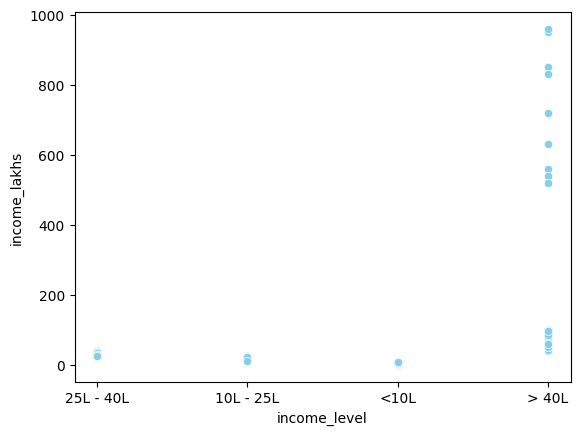

In [ ]:
sns.scatterplot(x="income_level", y="income_lakhs", data=df.dropna(), color='skyblue')
plt.show()

### Drop Null Values

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Check duplicate Values

In [ ]:
df.duplicated().sum()

np.int64(0)

### Check Outliers

In [ ]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


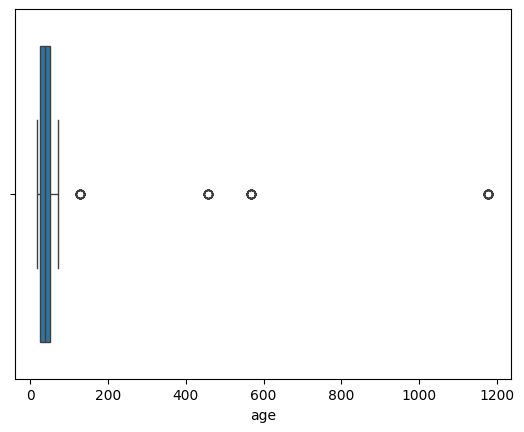

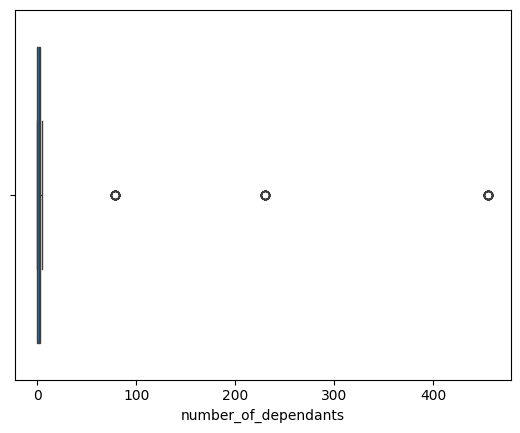

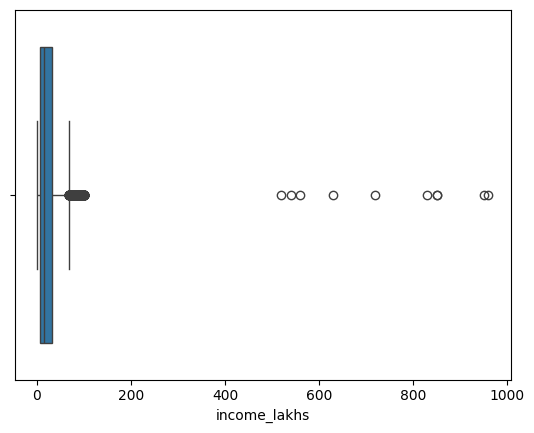

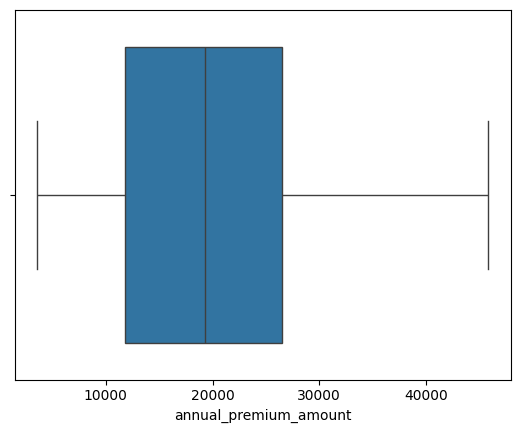

In [ ]:
for column in numerical_column:
    sns.boxplot(x=df[column])
    plt.show()

#### Age Outliers

In [ ]:
df[df.age>100]['age'].unique()

array([ 128, 1178,  567,  456])

In [ ]:
df_copy=df[df.age<=100].copy()

#### Number of dependans outliers

In [ ]:
df_copy['number_of_dependants'].unique()

array([  2,   5,   0,   3,   1,   4, 456,  78, 230])

In [ ]:
df_copy=df_copy[df_copy['number_of_dependants']<=5].copy()

#### Income lakhs outliers

In [ ]:
def get_iqr_bounds(col):
    Q1, Q3=col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound,upper_bound

In [ ]:
lower_bound_il,upper_bound_il=get_iqr_bounds(df_copy['income_lakhs'])

In [ ]:
lower_bound_il,upper_bound_il

(-31.5, 68.5)

In [ ]:
quantile_treshold=df_copy.income_lakhs.quantile(0.999)

In [ ]:
quantile_treshold

np.float64(155.86000000068452)

In [ ]:
df_copy=df_copy[df_copy.income_lakhs <= quantile_treshold].copy()

In [ ]:
df_copy.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9858.000000,9858.000000,9858.000000,9858.000000
mean,37.764760,1.919963,22.683709,19513.853419
std,13.976268,1.503027,22.453283,8900.593367
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11777.000000
50%,37.000000,2.000000,16.000000,19331.500000
75%,50.000000,3.000000,31.000000,26505.750000
max,72.000000,5.000000,100.000000,45854.000000


### Exploratory Data Analysis

#### Univariate Analysis

##### Numerical Variable Analysis

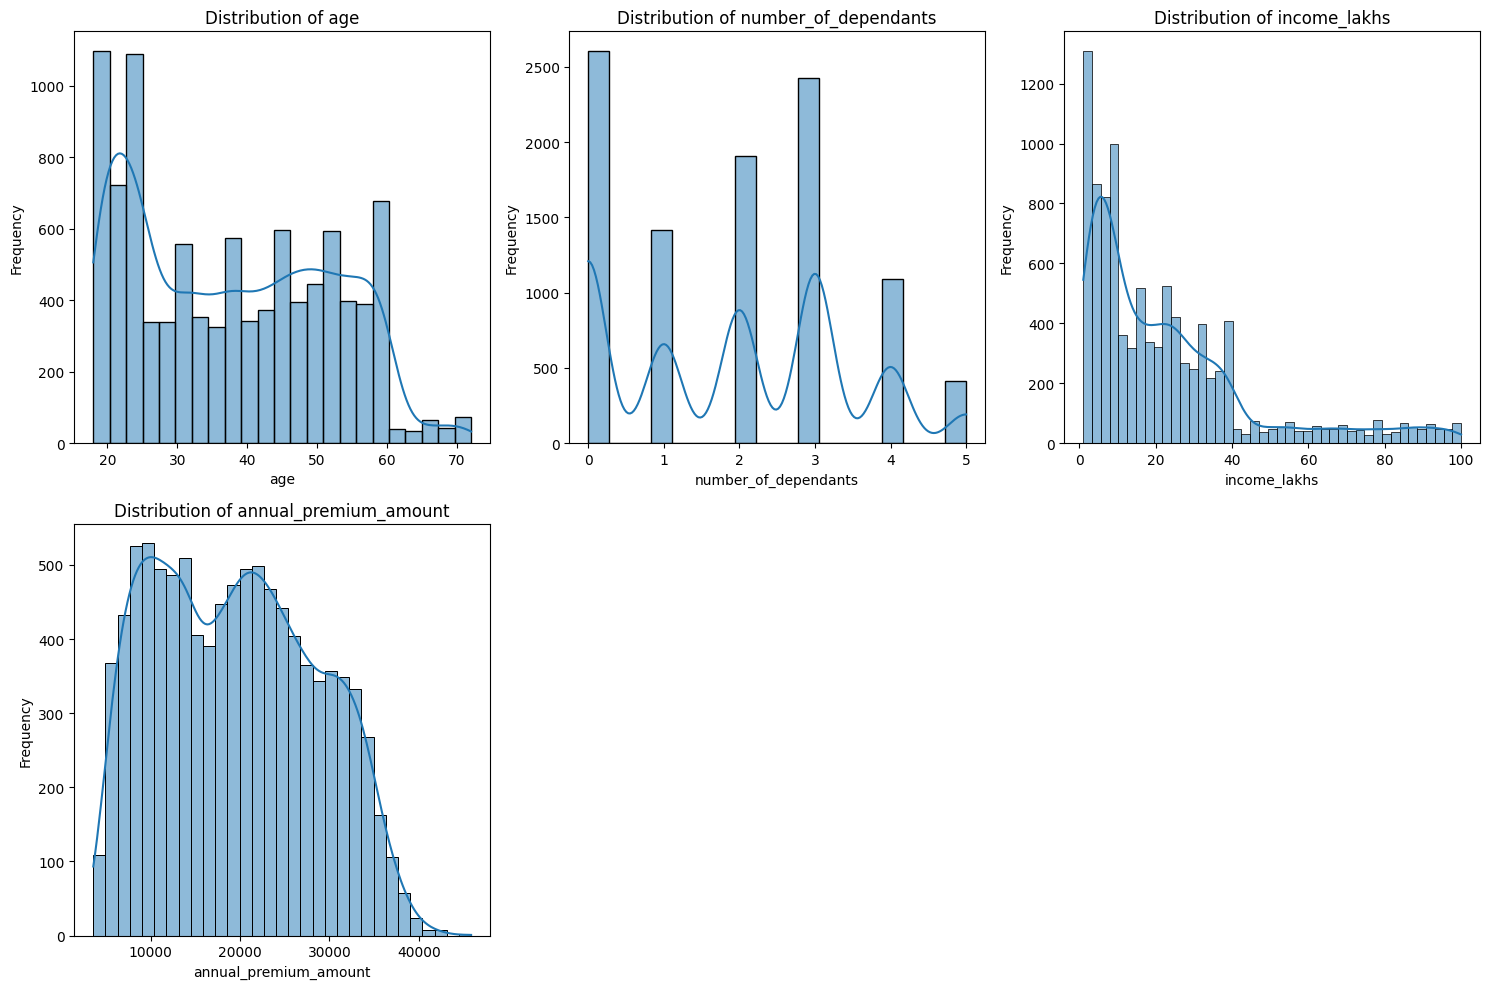

In [ ]:
numerical_columns = df_copy.select_dtypes(include=np.number).columns  # Get only numerical columns
num_cols = len(numerical_columns)

# Determine the number of rows and columns for the subplot grid
# You can adjust these based on the number of columns and your desired layout
num_rows = (num_cols + 2) // 3  # Example: roughly 3 columns per row
num_cols_per_row = min(num_cols, 3) # Ensure we don't have more columns than needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, column in enumerate(numerical_columns):
    sns.histplot(df_copy[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}') # Add a title to each subplot
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if the number of columns isn't a perfect multiple
if num_cols < num_rows * num_cols_per_row:
    for j in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

##### Categorical Variable Analysis

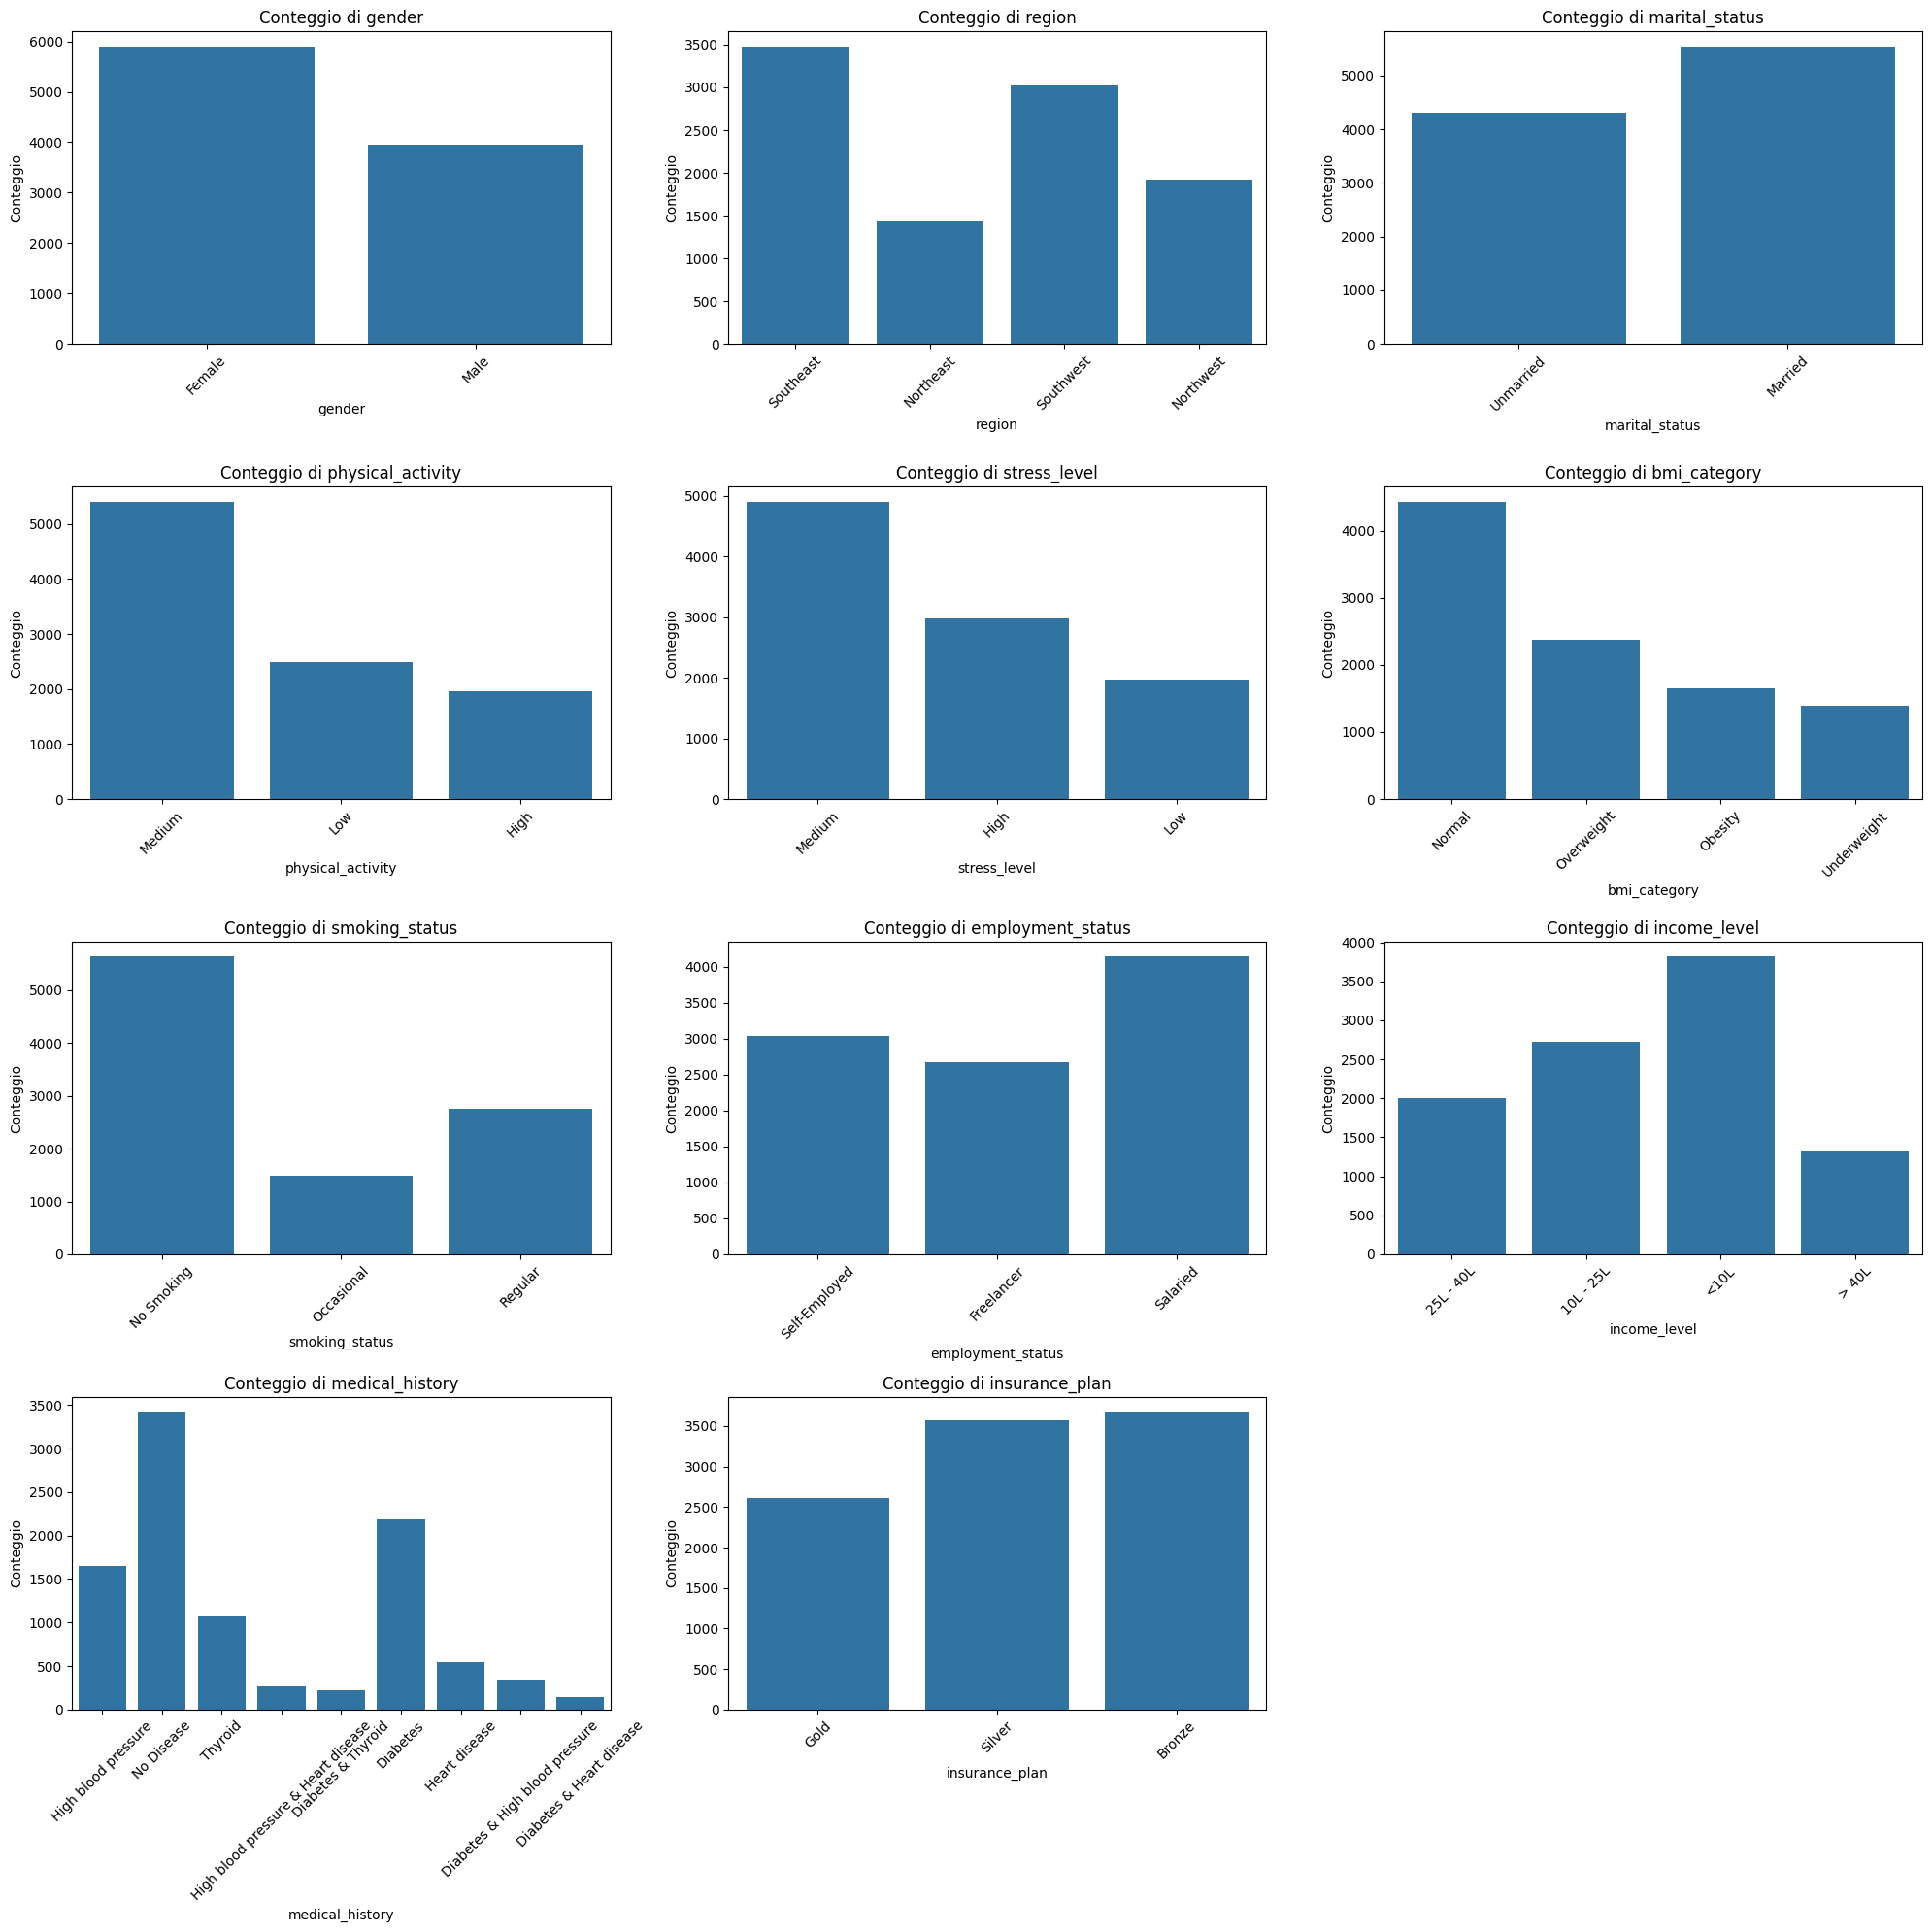

In [ ]:
# Assicurati che 'categorical_columns' contenga i nomi delle tue colonne categoriche
categorical_columns = df_copy.select_dtypes(include='object').columns # Verifica che selezioni le colonne corrette
num_cols = len(categorical_columns)

# Calcola il numero di righe e colonne per la griglia di subplot
num_rows = (num_cols + 2) // 3
num_cols_per_row = min(num_cols, 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.countplot(x=df_copy[column], ax=axes[i])
    axes[i].set_title(f'Conteggio di {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Conteggio')
    axes[i].tick_params(axis='x', rotation=45)

# Rimuovi i subplot non utilizzati
if num_cols < num_rows * num_cols_per_row:
    for j in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Bivariant Analysis

##### Numerical Features vs annual premium

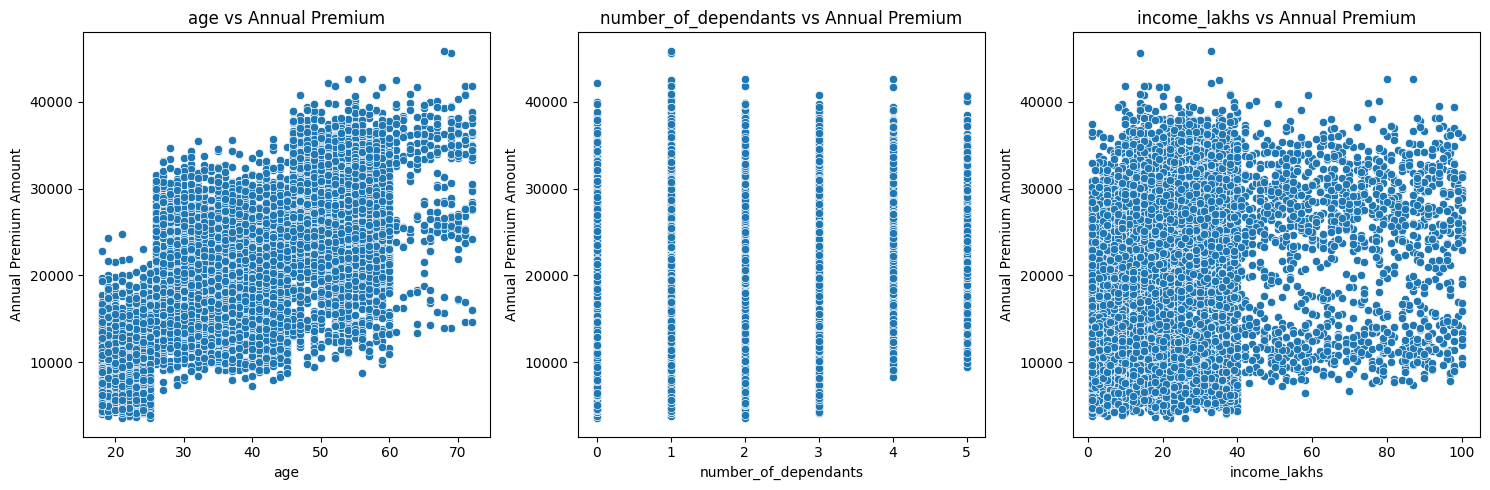

In [ ]:
# Assicurati che 'numerical_column' contenga i nomi delle tue colonne numeriche
numerical_columns = df_copy.select_dtypes(include=np.number).columns.tolist()
numerical_columns_to_plot = [col for col in numerical_columns if col != "annual_premium_amount"]
num_cols = len(numerical_columns_to_plot)

# Calcola il numero di righe e colonne per la griglia di subplot
num_rows = (num_cols + 2) // 3
num_cols_per_row = min(num_cols, 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns_to_plot):
    sns.scatterplot(data=df_copy, x=col, y="annual_premium_amount", ax=axes[i])
    axes[i].set_title(f'{col} vs Annual Premium')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Annual Premium Amount')

# Rimuovi i subplot non utilizzati
if num_cols < num_rows * num_cols_per_row:
    for j in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Employment Status With Numerical Features

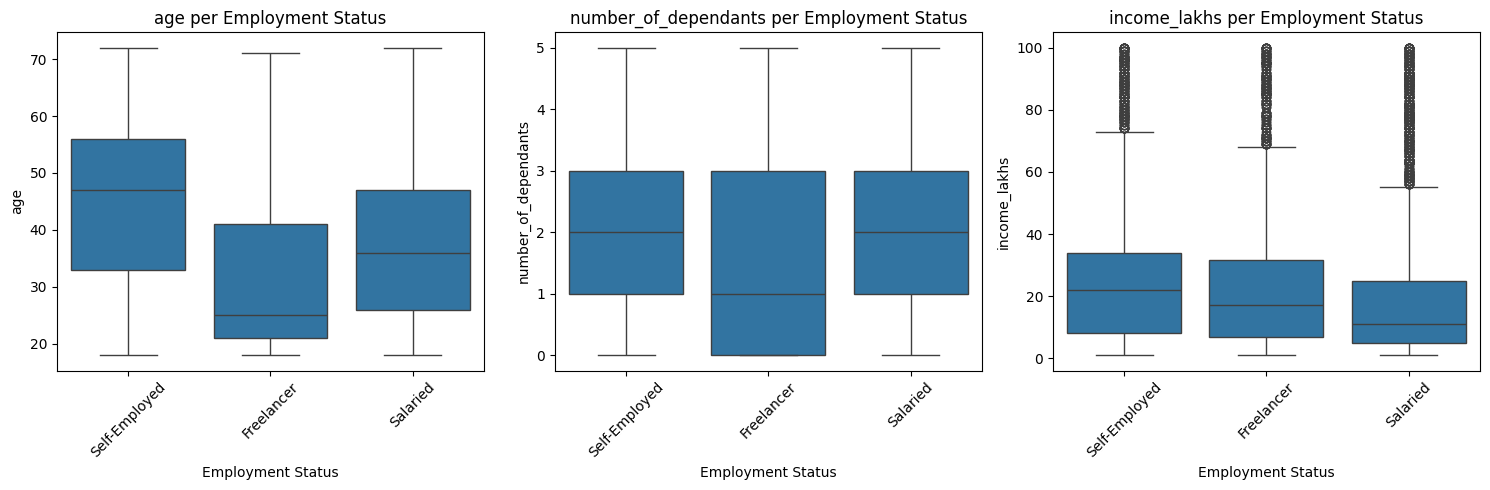

In [ ]:
numerical_columns = df_copy.select_dtypes(include=np.number).columns.tolist()
numerical_columns_to_plot = [col for col in numerical_columns if col != "annual_premium_amount"]
num_cols = len(numerical_columns_to_plot)
num_rows = (num_cols + 2) // 3
num_cols_per_row = min(num_cols, 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns_to_plot):
    sns.boxplot(data=df_copy, x="employment_status", y=col, ax=axes[i])
    axes[i].set_title(f'{col} per Employment Status')
    axes[i].set_xlabel('Employment Status')
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

if num_cols < num_rows * num_cols_per_row:
    for j in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Stress Factor With Medical History

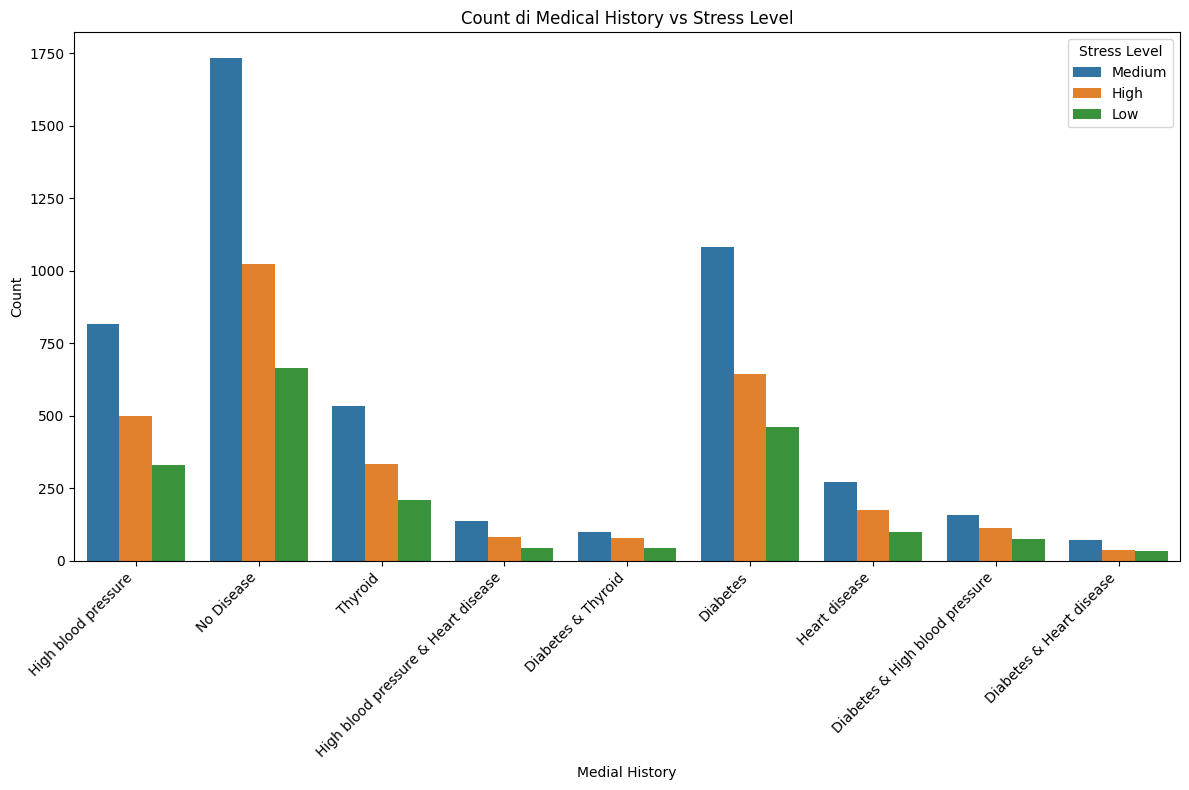

In [ ]:
# Imposta le dimensioni della figura prima di creare il plot
plt.figure(figsize=(12, 8))  # Puoi modificare i valori (larghezza, altezza) a tuo piacimento

sns.countplot(x='medical_history', hue='stress_level', data=df_copy)

# Aggiungi un titolo e delle etichette per chiarezza
plt.title('Count di Medical History vs Stress Level')
plt.xlabel('Medial History')
plt.ylabel('Count')

# Ruota le etichette sull'asse x se necessario per evitare sovrapposizioni
plt.xticks(rotation=45, ha='right')

# Mostra la legenda (dovrebbe essere automatica con 'hue')
plt.legend(title='Stress Level')

plt.tight_layout()  # Ottimizza il layout per evitare che gli elementi si sovrappongano
plt.show()

#### Multivariant Analysis

In [ ]:
for col in categorial_column:
    print(col,":",df_copy[col].unique())

KeyError: 'Annual_Premium_Amount'

##### Insurance Level Vs Insurance plan

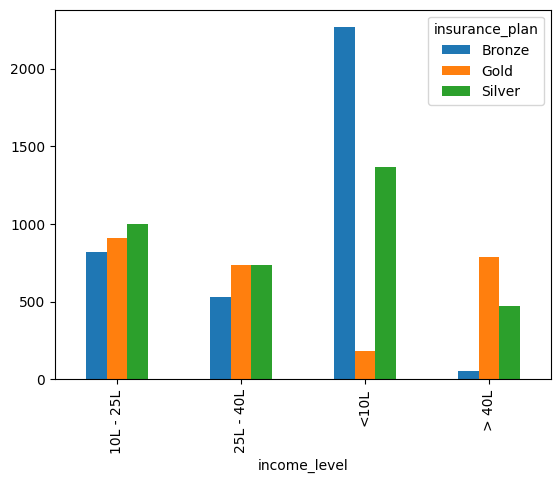

In [ ]:
crosstab=pd.crosstab(df_copy["income_level"],df_copy["insurance_plan"])
crosstab.plot(kind="bar")
plt.show()

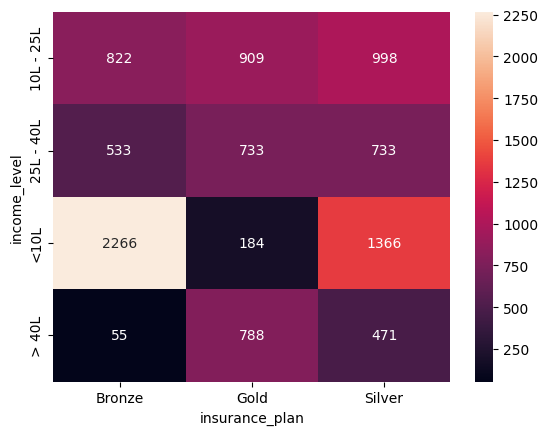

In [ ]:
sns.heatmap(crosstab,annot=True,fmt="d")
plt.show()

##### Encoding Categorical Variables

In [ ]:
risk_scores={
    "Diabetes":6,
    "Heart disease":8,
    "High blood pressure":6,
    "Thyroid":5,
    "No Disease":0,
    "None":0
}
df2[["disease1","disease2"]]=df2["medical_history"].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.head(10)